In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
df = pd.read_csv("..\data\cleaned_insurance.csv")
print(df.head())

X = df.drop("charges", axis=1)
y = df["charges"]

   age  sex     bmi  children  smoker      charges  region_northwest  \
0   19    0  27.900         0       1  16884.92400                 0   
1   18    1  33.770         1       0   1725.55230                 0   
2   28    1  33.000         3       0   4449.46200                 0   
3   33    1  22.705         0       0  21984.47061                 1   
4   32    1  28.880         0       0   3866.85520                 1   

   region_southeast  region_southwest  
0                 0                 1  
1                 1                 0  
2                 1                 0  
3                 0                 0  
4                 0                 0  


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# evaluating the model, tells us if a linear model is appropriate to use
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.3f}")

# more information on the model coefficients
coefficients = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": model.coef_
}).sort_values(by="Coefficient", ascending=False)

print(coefficients)

RMSE: 5796.28
R² Score: 0.784
            Feature   Coefficient
4            smoker  23651.128856
3          children    425.278784
2               bmi    337.092552
0               age    256.975706
1               sex    -18.591692
5  region_northwest   -370.677326
6  region_southeast   -657.864297
7  region_southwest   -809.799354


- Good R2 score, indicates that the **model explains a large proportion of the variance in the dependent variable**, which is hospital costs, showing a good fit between the observed data and the predicted values. However, there is unexplained variability in hospital costs that is not captured by the model - Potential heteroskedasticity in data
- RMSE quite high, might be missing obvious relationships

In [26]:
# test - predicting hospital costs for a new patient with same features as in dataframe
new_patient = pd.DataFrame([{
    "age": 45,
    "sex": 1,
    "bmi": 28.7,
    "children": 2,
    "smoker": 1,
    "region_northwest": 1,
    "region_southeast": 0,
    "region_southwest": 0}])

predicted_charge = model.predict(new_patient)[0]
print(f"Predicted insurance charge for new patient: ${predicted_charge:,.2f}")

Predicted insurance charge for new patient: $33,419.66


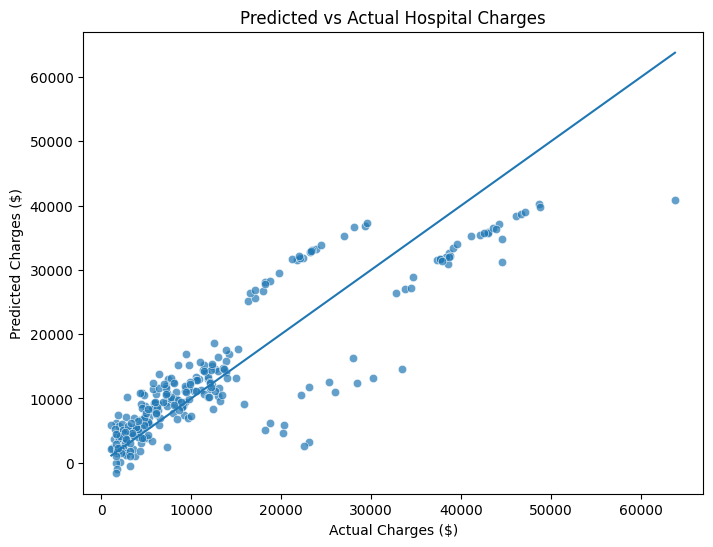

In [27]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()])
plt.title("Predicted vs Actual Hospital Charges")
plt.xlabel("Actual Charges ($)")
plt.ylabel("Predicted Charges ($)")
plt.show()

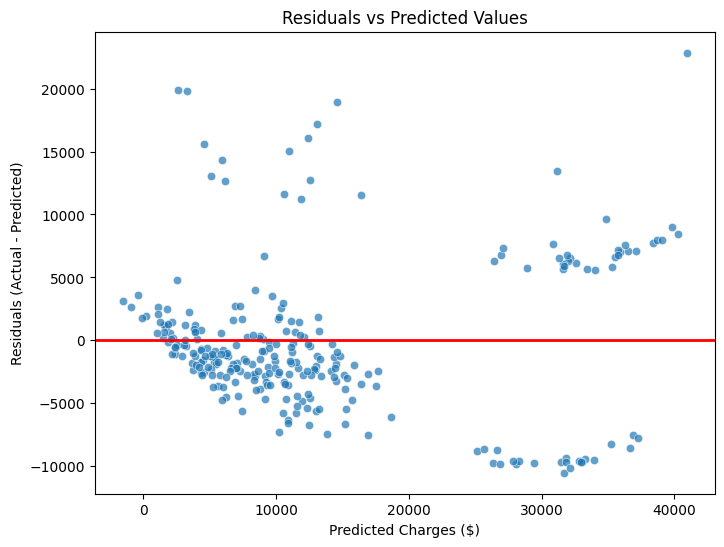

In [28]:
# residual plot to see if linear regression is a good fit
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.7)
plt.axhline(0, color='red', linewidth=2)
plt.title("Residuals vs Predicted Values")
plt.xlabel("Predicted Charges ($)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.show()

- The residual values in the residual plot are not evenly distributed horizontally and vertically, suggesting a **violation of the homoscedasticity hypothesis of linear models**. There is a cluster around a hospital charge of $10 000, which indicates that the model is effective at predicting lower charges, but not higher charges.

In [ ]:
# creating a comparison dataframe for predicted vs actual costs
comparison_df = pd.DataFrame({"Actual": y_test.values,"Predicted": y_pred})
print(comparison_df.head(20))

         Actual     Predicted
0    9095.06825   8969.550274
1    5272.17580   7068.747443
2   29330.98315  36858.410912
3    9301.89355   9454.678501
4   33750.29180  26973.173457
5    4536.25900  10864.113164
6    2117.33885    170.280841
7   14210.53595  16903.450287
8    3732.62510   1092.430936
9   10264.44210  11218.343184
10  18259.21600  28101.684553
11   7256.72310   9377.734602
12   3947.41310   5263.059518
13  46151.12450  38416.042211
14  48673.55880  40255.823393
15  44202.65360  37098.253531
16   9800.88820  15240.393923
17  42969.85270  35912.882644
18   8233.09750   9112.523987
19  21774.32215  31461.921089


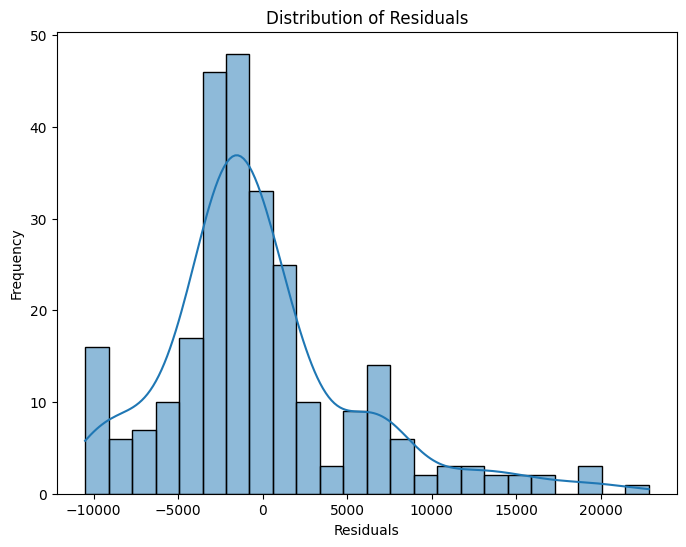

In [30]:
# checking distribution of residuals, if normally distributed, then good fit
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.title("Distribution of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

- Distribution roughly centered around 0, model consistent in its lower charges predictions
- **Non symmetric distribution**: Long right tail, meaning the model underestimates high hospital charges. Model is not optimal for estimating costly hospital visits, could be missing some relationships between features
- This suggests that the model **violates the normality assumption** that is necessary for linear regression, which happens in real life insurance cases.

In [31]:
# trying this process with a log-transformation of the hospital charges variable
# lowers the interpretability of the model but might improve performance

y_log = np.log1p(y)   # log(1 + y) transformation of the dependent variable

X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

model_log = LinearRegression()
model_log.fit(X_train, y_train_log)

y_pred_log = model_log.predict(X_test)
y_pred = np.expm1(y_pred_log)   # inverse of log1p to bring it back to dollar scale
y_test = np.expm1(y_test_log)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.3f}")


RMSE: 7814.06
R² Score: 0.607


- Notice a higher RMSE and lower R2 score, indicating that the model is not getting better using this method.

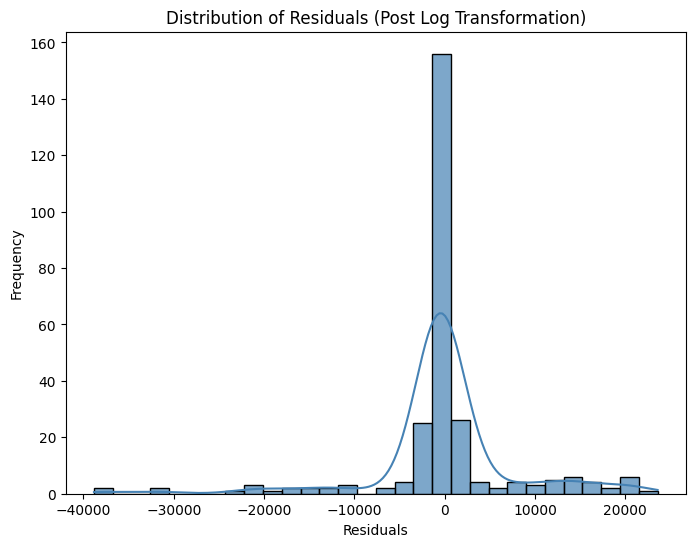

In [35]:
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30, color='steelblue', alpha=0.7)
plt.title("Distribution of Residuals (Post Log Transformation)")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

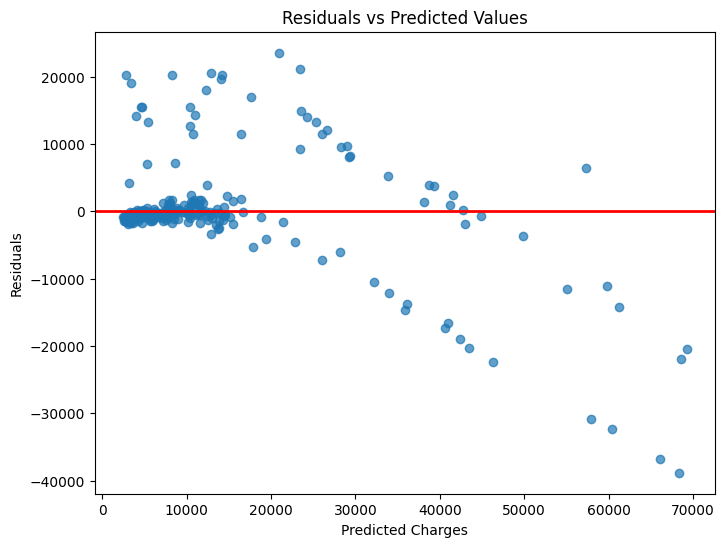

In [36]:
plt.figure(figsize=(8,6))
plt.scatter(x=y_pred, y=residuals, alpha=0.7)
plt.axhline(0, color='red', linewidth=2)
plt.title("Residuals vs Predicted Values")
plt.xlabel("Predicted Charges")
plt.ylabel("Residuals")
plt.show()
